# Predicting Stock Prices with Neural Networks
* As mentioned, can you use more hidden layers in the neural network stock predictor and re-run the model fine-tuning? Can you get a better result, maybe using dropout and early stopping?


* We will build the stock predictor with TensorFlow in this section. 
* We will start with feature generation and data preparation. 
* Then, we'll build our Sequential model with two hidden layers.
* We'll fine-tune the network incorporating early-stopping 
* Finally, we'll make predictions and evaluate our model's performance.


## Step 1: Loading the data
* We'll use the generate_features function that we developed in Chapter 7: Predicting Stock Prices with Regression Algorithms
* This data consists of stock prices from the DJI index. 
* After applying the function, we'll have 38 features and 2171 samples to work with. 

In [1]:
# In order to prepare the dataset and transform the features, we need to
# perform some operations on the initial dataset (formatting)
import pandas as pd
import numpy as np

# Storing the data in a dataframe and renaming Price and Vol to Close and Volume
df_raw = pd.read_csv("./dataset/doj_historical.csv", index_col="Date", parse_dates=True)

df_raw.rename(columns = {"Price" : "Close", "Vol.": "Volume" }, inplace = True)
# Evaluating the columns and the content of the dataframe
df_raw.head(5)

# We have six original columns and we'll transform them to get more dimensions

# We need to drop the Change % column
df_raw.drop("Change %", axis = 1, inplace = True)

# Find rows with '-' in any of the columns
filtered_df = df_raw[df_raw.apply(lambda row: row.str.contains('-')).any
(axis=1)]
print("\nRows with '-' symbol:")
print(filtered_df)

# We'll delete the M for all values and multiply for 1000,
# All other values that contain "-", we'll replace them with nan
df_raw['Volume'] = df_raw['Volume'].apply(lambda x: 1000 * float(x.replace("M",
                                                                        ""))
if x != "-" else float("nan"))

df_raw['Volume']

from sklearn.impute import SimpleImputer

# Use the SimpleImputer to convert all missing values from nan to the mean of
# all other rows
volume_transformed = SimpleImputer(missing_values = np.nan, strategy = "mean")
volume_transformed.fit(df_raw['Volume'].values.reshape(-1, 1))
volume_transformed.transform(df_raw['Volume'].values.reshape(-1, 1))

df_raw['Volume']

# Making sure that all values are of type float since there are some
# characters (commas, suffixes) that will stop us from using the functions
def remove_commas(value):
    """
    This function converts strings in our rows into floats. It also removes
    commas and the M suffix in the column for volume.
    @param value: str, The value in the current row
    @return: float, a clean version of the original data
    """
    return float(value.replace(",", ""))

# Applying the custom function to all elements in the dataframe
df_raw.iloc[:,:-1] = df_raw.iloc[:,:-1].applymap(remove_commas)





Rows with '-' symbol:
                Close       Open       High        Low Volume
Date                                                         
2010-05-13  10,782.95  10,896.61  10,952.84  10,752.72      -
2010-05-12  10,896.91  10,742.15  10,941.88  10,725.81      -
2010-05-11  10,748.26  10,780.00  10,888.30  10,653.71      -
2010-05-10  10,785.14  10,386.18  10,880.14  10,386.18      -
2010-05-07  10,380.43  10,519.42  10,622.27  10,221.50      -
...               ...        ...        ...        ...    ...
2009-01-09   8,599.18   8,738.80   8,800.45   8,541.75      -
2009-01-08   8,742.46   8,769.94   8,807.14   8,593.52      -
2009-01-07   8,769.70   8,996.94   8,996.94   8,690.45      -
2009-01-06   9,015.10   8,954.57   9,175.19   8,868.07      -
2009-01-05   8,952.89   9,027.13   9,093.47   8,841.70      -

[342 rows x 5 columns]


In [2]:
import nbimporter
from preparing_dji_data import generate_features

# Creating a new, enhanced dataset:
data = generate_features(df_raw)
# The dimensions of our new dataset: 38, 2171
print(len(data.columns), len(data.values))

# Sorting first in reverse order:
data.sort_index(inplace=True, ascending=False)
data_asc = data.sort_index(inplace=False, ascending=True)  # New line

# Taking a look at what the data with the new features looks like
print(data.round(decimals=3).head(5))

38 2171
                open    open_1   close_1    high_1     low_1  volume_1   
Date                                                                     
2018-12-27  22629.06  23213.61   23062.4  23381.88  22981.33  336510.0  \
2018-12-26  21857.73  22629.06  23138.82  23138.89  22267.42  407940.0   
2018-12-24  22317.28  21857.73  22878.45  22878.92  21712.53  433080.0   
2018-12-21  22871.74  22317.28   21792.2  22339.87   21792.2  308420.0   
2018-12-20  23224.12  22871.74  22445.37  23254.59  22396.34  900510.0   

            avg_price_5  avg_price_30  avg_price_365  ratio_avg_price_5_30   
Date                                                                         
2018-12-27    23171.096     23985.192      26337.481                 0.966  \
2018-12-26    23112.228     23916.566      26315.630                 0.966   
2018-12-24    23150.674     23838.006      26292.841                 0.971   
2018-12-21    22839.866     23697.768      26266.161                 0.964   
2018-

In [3]:
# Defining the dates for our training and testing dataset (chronologically)
start_train = '2010-05-13'
end_train = '2017-12-31'
start_test = '2018-01-01'
end_test = '2018-12-27'

# Splitting our data
data_train = data_asc.loc[start_train:end_train]  # Updated
data_test = data_asc.loc[start_test:end_test]  # Updated

# We have 1922 samples for training and 249 for testing.
train_sample_num = data_train.shape[0]
test_sample_num = data_test.shape[0]
print(f"Training: {train_sample_num}, Testing: {test_sample_num}")
print(f"The ratio between training and testing is: {train_sample_num  /(train_sample_num + test_sample_num):.2f}% ")

# We have a 90/10 split.


Training: 1922, Testing: 249
The ratio between training and testing is: 0.89% 


In [4]:
# Dropping the target from the training dataset
X_train = data_train.drop('close', axis=1).values
y_train = data_train['close'].values

X_test = data_test.drop('close', axis=1).values
y_test = data_test['close'].values

## Step 2: Normalizing and splitting the data using StandardScaler and train_test_split
* In this section we'll normalize our data and we'll further split it into train and validation sets. 

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

# We define it like this because we'll perform further splitting later
X_train_validation_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Splitting the training further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_validation_scaled, y_train, test_size=0.20, random_state = 42)

## Step 3: Building and compiling the model
* We'll use the Sequential model from Keras with Dropout of 50%, Early Stopping after 200 epochs, Adam Optimizer with MSE as the loss function and ReLU activation functions for both of the hidden layers.
* We'll define a learning Rate = 0.1, 100 epochs 

In [6]:
# Due to an error with tensorflow, trying to convert the values to float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32)

X_test_scaled = X_test_scaled.astype(np.float32)
y_test = y_test.astype(np.float32)

In [15]:
# Building our model using Tensorflow and Keras
import tensorflow as tf
nn_model = tf.keras.Sequential([
    # The network we begin with has one hidden layer with 32 nodes 
    tf.keras.layers.Dense(32, activation = 'relu', input_shape=[X_train.shape[1],]),
    tf.keras.layers.Dropout(0.5),
    # Followed by a 64 Neuron Layer
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    # And a final output layer
    tf.keras.layers.Dense(1)
])

# Compiling the model
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), 
                                                   loss = tf.keras.losses.MeanSquaredError())

# Creating the Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

# Fitting the model
nn_model.fit(X_train, y_train, epochs = 1000, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

nn_model.summary()

Epoch 1/1000
49/49 [==============================] - 1s 4ms/step - loss: 82380912.0000 - val_loss: 13187077.0000
Epoch 2/1000
49/49 [==============================] - 0s 2ms/step - loss: 28099320.0000 - val_loss: 7269731.0000
Epoch 3/1000
49/49 [==============================] - 0s 2ms/step - loss: 24527650.0000 - val_loss: 3944061.2500
Epoch 4/1000
49/49 [==============================] - 0s 2ms/step - loss: 24129770.0000 - val_loss: 5309534.0000
Epoch 5/1000
49/49 [==============================] - 0s 2ms/step - loss: 22734370.0000 - val_loss: 6337789.5000
Epoch 6/1000
49/49 [==============================] - 0s 2ms/step - loss: 22187088.0000 - val_loss: 7555904.5000
Epoch 7/1000
49/49 [==============================] - 0s 2ms/step - loss: 21543896.0000 - val_loss: 1999629.6250
Epoch 8/1000
49/49 [==============================] - 0s 2ms/step - loss: 21505014.0000 - val_loss: 1429781.1250
Epoch 9/1000
49/49 [==============================] - 0s 2ms/step - loss: 21970504.0000 - val_l

49/49 [==============================] - 0s 2ms/step - loss: 11197930.0000 - val_loss: 8783637.0000
Epoch 73/1000
49/49 [==============================] - 0s 2ms/step - loss: 10424440.0000 - val_loss: 4160384.7500
Epoch 74/1000
49/49 [==============================] - 0s 2ms/step - loss: 9795160.0000 - val_loss: 6050981.5000
Epoch 75/1000
49/49 [==============================] - 0s 2ms/step - loss: 9926447.0000 - val_loss: 7607639.0000
Epoch 76/1000
49/49 [==============================] - 0s 2ms/step - loss: 9586559.0000 - val_loss: 2992308.7500
Epoch 77/1000
49/49 [==============================] - 0s 2ms/step - loss: 10085118.0000 - val_loss: 6410193.5000
Epoch 78/1000
49/49 [==============================] - 0s 2ms/step - loss: 8853164.0000 - val_loss: 5552109.0000
Epoch 79/1000
49/49 [==============================] - 0s 2ms/step - loss: 10773283.0000 - val_loss: 4317316.0000
Epoch 80/1000
49/49 [==============================] - 0s 2ms/step - loss: 8891872.0000 - val_loss: 248351

49/49 [==============================] - 0s 2ms/step - loss: 7301172.0000 - val_loss: 3002494.0000
Epoch 145/1000
49/49 [==============================] - 0s 2ms/step - loss: 7391379.0000 - val_loss: 1816311.7500
Epoch 146/1000
49/49 [==============================] - 0s 2ms/step - loss: 7208048.5000 - val_loss: 680517.8125
Epoch 147/1000
49/49 [==============================] - 0s 2ms/step - loss: 6666886.0000 - val_loss: 1684194.7500
Epoch 148/1000
49/49 [==============================] - 0s 2ms/step - loss: 7490450.0000 - val_loss: 1238986.5000
Epoch 149/1000
49/49 [==============================] - 0s 2ms/step - loss: 7347886.0000 - val_loss: 1016405.3750
Epoch 150/1000
49/49 [==============================] - 0s 2ms/step - loss: 7149506.0000 - val_loss: 282542.4375
Epoch 151/1000
49/49 [==============================] - 0s 2ms/step - loss: 9739192.0000 - val_loss: 5161235.5000
Epoch 152/1000
49/49 [==============================] - 0s 2ms/step - loss: 8098861.5000 - val_loss: 1545

49/49 [==============================] - 0s 2ms/step - loss: 8190397.5000 - val_loss: 2413578.5000
Epoch 217/1000
49/49 [==============================] - 0s 2ms/step - loss: 8451684.0000 - val_loss: 3253338.5000
Epoch 218/1000
49/49 [==============================] - 0s 2ms/step - loss: 8001469.5000 - val_loss: 1725038.7500
Epoch 219/1000
49/49 [==============================] - 0s 2ms/step - loss: 8063069.5000 - val_loss: 1873182.8750
Epoch 220/1000
49/49 [==============================] - 0s 2ms/step - loss: 8131621.5000 - val_loss: 1507637.3750
Epoch 221/1000
49/49 [==============================] - 0s 2ms/step - loss: 8525288.0000 - val_loss: 3234522.5000
Epoch 222/1000
49/49 [==============================] - 0s 2ms/step - loss: 9379670.0000 - val_loss: 1357262.7500
Epoch 223/1000
49/49 [==============================] - 0s 2ms/step - loss: 8808014.0000 - val_loss: 1255548.3750
Epoch 224/1000
49/49 [==============================] - 0s 2ms/step - loss: 8386033.0000 - val_loss: 20

49/49 [==============================] - 0s 2ms/step - loss: 7513670.5000 - val_loss: 1171076.3750
Epoch 289/1000
49/49 [==============================] - 0s 2ms/step - loss: 7278790.5000 - val_loss: 1964223.6250
Epoch 290/1000
49/49 [==============================] - 0s 2ms/step - loss: 8197079.5000 - val_loss: 4368968.0000
Epoch 291/1000
49/49 [==============================] - 0s 2ms/step - loss: 8545544.0000 - val_loss: 1165502.5000
Epoch 292/1000
49/49 [==============================] - 0s 2ms/step - loss: 8172524.5000 - val_loss: 1529852.3750
Epoch 293/1000
49/49 [==============================] - 0s 2ms/step - loss: 7691361.5000 - val_loss: 2160206.2500
Epoch 294/1000
49/49 [==============================] - 0s 2ms/step - loss: 8541095.0000 - val_loss: 1007374.9375
Epoch 295/1000
49/49 [==============================] - 0s 2ms/step - loss: 7928720.0000 - val_loss: 1037118.7500
Epoch 296/1000
49/49 [==============================] - 0s 2ms/step - loss: 7834305.0000 - val_loss: 12

## Step 4: Predicting and evaluating the model

In [16]:
# Predicting new values
predictions = nn_model.predict(X_test_scaled)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f'MSE: {mean_squared_error(y_test,predictions):.3f}')
print(f'MAE: {mean_absolute_error(y_test, predictions):.3f}')
print(f'R^2: {r2_score(y_test, predictions):.3f}')

8/8 [==============================] - 0s 857us/step
MSE: 2012983.250
MAE: 1215.825
R^2: -2.040


## Step 5: Fine Tunning the model to achieve an optimal R2
* We'll use Keras Tuner to perform hyperparameter tunner.   

In [9]:
# I mport the libraries and define a function that creates the model with tunable hyperparameters
from keras_tuner import RandomSearch
import tensorflow as tf

def build_model(hp):
    """
    Build a neural network model with tunable hyperparameters using Keras Tuner.
    
    :param hp: HyperParameters object from Keras Tuner
    :return: Compiled Keras model with specified hyperparameters
    """
    
    # Create a sequential neural network model
    nn_model = tf.keras.Sequential([
        
        # Add a dense layer with tunable number of units and ReLU activation
        tf.keras.layers.Dense(
            units=hp.Int('units', min_value=16, max_value=64, step=8),
            activation='relu',
            input_shape=[X_train.shape[1],]),
        
        # Add a dropout layer with tunable dropout rate
        tf.keras.layers.Dropout(
            hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)),
        
        # Add a dense layer with tunable number of units and ReLU activation
        tf.keras.layers.Dense(
            units=hp.Int('units', min_value=32, max_value=128, step=16),
            activation='relu',
        ),
        
        # Add a dropout layer with tunable dropout rate
        tf.keras.layers.Dropout(
            hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)),
        
        # Add the output dense layer with a single unit
        tf.keras.layers.Dense(1)
    ])
    
    # Compile the model with tunable learning rate and fixed loss function
    nn_model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=0.002, max_value=0.2, sampling='LOG')),
        loss=tf.keras.losses.MeanSquaredError())
    
    return nn_model



In [10]:
# Create a random search tuner with specified objective, number of trials, and project name
tuner = RandomSearch(
    build_model, 
    objective='val_loss',
    max_trials = 20,
    executions_per_trial=2,
    directory='.',
    project_name='stock_price_final'
)

# Display the search space summary
tuner.search_space_summary()

# Define the Early Stopping callback to stop training when validation loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

# Perform the hyperparameter search by training the model with different hyperparameter combinations
tuner.search(X_train, y_train,
            epochs=1000,
            validation_data=(X_val, y_val), 
            callbacks=[early_stopping])

# Display the results summary
tuner.results_summary()


Trial 20 Complete [00h 02m 07s]
val_loss: 37260.822265625

Best val_loss So Far: 9270.105712890625
Total elapsed time: 00h 42m 15s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in .\stock_price_final
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 16 summary
Hyperparameters:
units: 48
dropout_rate: 0.1
learning_rate: 0.007630310573304127
Score: 9270.105712890625

Trial 07 summary
Hyperparameters:
units: 32
dropout_rate: 0.2
learning_rate: 0.007576319036143053
Score: 12396.5673828125

Trial 05 summary
Hyperparameters:
units: 32
dropout_rate: 0.2
learning_rate: 0.003779853356898398
Score: 20719.7978515625

Trial 13 summary
Hyperparameters:
units: 16
dropout_rate: 0.1
learning_rate: 0.016095565075526386
Score: 26621.21484375

Trial 09 summary
Hyperparameters:
units: 64
dropout_rate: 0.1
learning_rate: 0.04727480485886523
Score: 26856.482421875

Trial 00 summary
Hyperparameters:
units: 24
dropout_rate: 0.2
learning_rate: 0.0141572805377025
Score: 2

### If the Kernel was restarted and we want to reload the model: 

In [11]:
from keras_tuner import RandomSearch

# Load the existing tuner from the saved directory
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='.',  # Use the same directory that you used for the original tuner
    project_name='stock_price_final'  # Use the same project name that you used for the original tuner
)

# Reload the tuner's state
tuner.reload()

# Get the best model and hyperparameters as before
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]

print("Best Hyperparameters:")
for hp_name in best_hyperparameters.values.keys():
    print(f"{hp_name}: {best_hyperparameters.get(hp_name)}")



INFO:tensorflow:Reloading Tuner from .\stock_price_final\tuner0.json
Best Hyperparameters:
units: 48
dropout_rate: 0.1
learning_rate: 0.007630310573304127


In [12]:
# Making sure that the best_model has the right hyperparameters
# Extract the hyperparameters from the best model
best_units = best_model.layers[0].units
best_dropout_rate = best_model.layers[1].rate
best_learning_rate = best_model.optimizer.get_config()['learning_rate']

# Print the hyperparameters
print("Best Units:", best_units)
print("Best Dropout Rate:", best_dropout_rate)
print("Best Learning Rate:", best_learning_rate)


Best Units: 48
Best Dropout Rate: 0.1
Best Learning Rate: 0.0076303105


## Final Step: Predicitng and Evaluating the model

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions using the best model
predictions = best_model.predict(X_test_scaled)

# Evaluate the model's performance using different metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print the evaluation results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


8/8 [==============================] - 0s 931us/step
Mean Absolute Error (MAE): 139.56664
Mean Squared Error (MSE): 28037.041
R-squared (R2): 0.9576585491916055


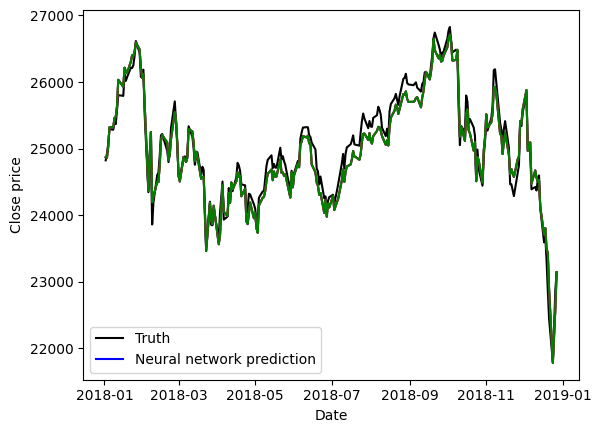

In [14]:
import matplotlib.pyplot as plt
plt.plot(data_test.index, y_test, c='k')
plt.plot(data_test.index, predictions, c='b')
plt.plot(data_test.index, predictions, c='r')
plt.plot(data_test.index, predictions, c='g')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(['Truth', 'Neural network prediction'])
plt.show()
